## Practical 7: Working with Text (Part 2)

The basics of Text Mining and NLP

| Complete | Part 1: Foundations | Part 2: Data | Part 3: Analysis |      |
|:---------|:--------------------|:-------------|:-----------------|-----:|
| 60%      | ▓▓▓▓▓▓▓▓            | ▓▓▓▓▓░       | ░░░░░░           | 7/10 |

A lot of the content here is provided to help you *understand* what
text-cleaning does and how it generates tokens that can be processed by
the various analytical approaches commonly-used in NLP. The best way to
think about this is as a practical in three parts, not all of which you
should expect to complete in this session:

1.  Tasks 1–3: these are largely focussed on the basics: exploring text
    and using regular expressions to find and select text.
2.  Tasks 4–5: this might seem like a *bit* of a detour, but it’s
    intended to show you in a more tangible way how ‘normalisation’
    works when we’re working with text. **You should feel free to stop
    here and return to the rest later.**
3.  Tasks 6–7: are about finding important vocabulary (think ‘keywords’
    and ‘significant terms’) in documents so that you can start to think
    about what is *distinctive* about documents and groups of documents.
    **This is quite useful and relatively easier to understand than what
    comes next!**
4.  Tasks 8–9: are about fully-fledged NLP using Latent Direclecht
    Allocation (topic modelling) and Word2Vec (words embeddings for use
    in clustering or similarity work).

The later parts are largely complete and ready to run; however, that
*doesn’t* mean you should just skip over them and think you’ve grasped
what’s happening and it will be easy to apply in your own analyses. I
would *not* pay as much attention to LDA topic mining since I don’t
think it’s results are that good, but I’ve included it here as it’s
still commonly-used in the Digital Humanities and by Marketing folks.
Word2Vec is much more powerful and forms the basis of the kinds of
advances seen in ChatGPT and other LLMs.

> **🔗 Connections**
>
> Working with text is unquestionably *hard*. In fact, *conceptually*
> this is probaly the most challenging practical of the term! But data
> scientists are *always* dealing with text because so much of the data
> that we collect (even more so thanks to the web) is not only
> text-based (URLs are text!) but, increasingly, unstructured (social
> media posts, tags, etc.). So while getting to grips with text is a
> challenge, it also uniquely positions you with respect to the skills
> and knowledge that other graduates are offering to employers.

## 1. Preamble

This practical has been written using `nltk`, but would be *relatively*
easy to rework using `spacy`. Most programmers tend to use one *or* the
other, and the switch wouldn’t be hard other than having to first load
the requisite language models:

In [1]:
import spacy

# `...web_md` and `...web_lg` are also options
corp = "en_core_web_sm"

try: 
    nlp = spacy.load(corp)
except OSError:
    spacy.cli.download(corp)
    nlp = spacy.load(corp)

You can [read about the models](https://spacy.io/models/en), and note
that they are also [available in other
languages](https://spacy.io/usage/models) besides English.

## 2. Setup

> **Difficulty Level: Low**
>
> But this is only because this has been worked out for you. Starting
> from sctach in NLP is *hard* so people try to avoid it as much as
> possible.

### 2.1 Required Modules

> **Note**
>
> Notice that the number of modules and functions that we import is
> steadily increasing week-on-week, and that for text processing we tend
> to draw on quite a wide range of utilies! That said, the three most
> commonly used are: `sklearn`, `nltk`, and `spacy`.

Standard libraries we’ve seen before.

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import math
import matplotlib.pyplot as plt

Vectorisers we will use from the ‘big beast’ of Python machine learning:
Sci-Kit Learn.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# We don't use this but I point out where you *could*
from sklearn.preprocessing import OneHotEncoder 

NLP-specific libraries that we will use for tokenisation, lemmatisation,
and frequency analysis.

In [4]:
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

try:
    from nltk.corpus import stopwords
except:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

Remaining libraries that we’ll use for processing and display text data.
Most of this relates to dealing with the various ways that text data
cleaning is *hard* because of the myriad formats it comes in.

In [5]:
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

This next is just a small utility function that allows us to output
Markdown (like this cell) instead of plain text:

In [6]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('Result!', "Here's my output...")

### 2.2 Loading Data

> **🔗 Connections**
>
> Because I generally want each practical to stand on its own (unless
> I’m trying to make a *point*), I’ve not moved this to a separate
> Python file (e.g. `utils.py`, but in line with what we covered back in
> the lectures on [Functions and
> Packages](https://jreades.github.io/fsds/sessions/week3.html#lectures),
> this sort of thing is a good candidate for being split out to a
> separate file to simplify re-use.

Remember this function from last week? We use it to save downloading
files that we already have stored locally. But notice I’ve made some
small changes… what do these do to help the user?

In [7]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it! We
    # also check for *very* small files that are 
    # likely to represent an incomplete download.
    if not os.path.isfile(dfn) or os.stat(dfn).st_size < 250:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

        # What's this doing???
        f_size = os.stat(dfn).st_size
        print(f"\tSize is {f_size/1024**2:,.0f} MB ({f_size:,} bytes)")

    else:
        print(f"Found {dfn} locally!")

        # And why is it here as well???
        f_size = os.stat(dfn).st_size
        print(f"\tSize is {f_size/1024**2:,.0f} MB ({f_size:,} bytes)")
        
    return dfn

> **Tip**
>
> For very large *non*-geographic data sets, remember that you can
> `use_cols` (or `columns` depending on the file type) to specify a
> subset of columns to load.

Load the main data set:

In [8]:
# Set download URL
ymd  = '2023-09-06'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-listings.geoparquet'

gdf = gpd.read_parquet( cache_data(url, os.path.join('data','geo')), 
                      columns=['geometry', 'listing_url', 'name', 
                               'description', 'amenities', 'price'])

gdf = gdf.to_crs('epsg:27700')

print(f"gdf has {gdf.shape[0]:,} rows and CRS is {gdf.crs.name}.")

Found data/geo/2023-09-06-listings.geoparquet locally!
    Size is 42 MB (43,985,171 bytes)
gdf has 85,134 rows and CRS is OSGB36 / British National Grid.

Load supporting Geopackages:

In [9]:
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
    Size is 1 MB (905,216 bytes)
Found data/geo/Water.gpkg locally!
    Size is 0 MB (208,896 bytes)
Found data/geo/Greenspace.gpkg locally!
    Size is 1 MB (1,146,880 bytes)
Done.

## 3. Exploratory Textual Analysis

> **🔗 Connections**
>
> If you plan to work with data post-graduation then you will *need* to
> become comfortable with Regular Expressions (aka. regexes). These are
> the focus of the [Patterns in
> Text](https://jreades.github.io/fsds/sessions/week7.html#lectures)
> lecture but they barely even scratch the surface of what regexes can
> do. They are *hard*, but they are powerful.

> **Tip**
>
> In a full text-mining application I would spend a lot more time on
> this stage: sampling, looking at descriptions in full, performing my
> analysis (the rest of the steps) and then coming back with a deeper
> understanding of the data to make further changes to the analysis.

It’s helpful to have a sense of what data look like before trying to do
something with them, but by default pandas truncates quite a lot of
output to keep it from overwhelming the display. For text processing,
however, you should probably change the amount of preview text provided
by pandas using the available options. *Note*: there are lots of other
options that you can tweak in pandas.

In [10]:
print(f"Default maximum column width: {pd.options.display.max_colwidth}") # What's this currently set to?
pd.options.display.max_colwidth=250   # None = no maximum column width (you probably don't want to leave it at this)
print(f"Now maximum column width set to: {pd.options.display.max_colwidth}")

Default maximum column width: 50
Now maximum column width set to: 250

### 3.1 The Description Field

> **Difficulty level: Moderate, because of the questions.**

To explore the description field properly you’ll need to filter out any
NA/NaN descriptions before sampling the result. *Hint*: you’ll need to
think about negation (`~`) of a method output that tells you if a field
*is NA*.

##### Question

``` python
gdf[???].sample(5, random_state=42)[['description']]
```

##### Answer

``` python
gdf[~gdf.description.isna()].sample(5, random_state=42)[['description']]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|  | description |
|----|----|
| id |  |
| 21898360 | A wonderful double room in harrow on the hill.\<br /\>\<br /\>Very quite and secure area\<br /\>Guests will have acces to all comunes areas in the flat, bathroom, kitchen, \<br /\>very spacious natural garden with table and chairs to to take your breakfa... |
| 40269638 | \- 3 Bedrooms 2 beds and 1 sofa bed\<br /\>- 2 Bathroom\<br /\>- 0.5 miles Underground Station \<br /\>- Free WiFi \<br /\>\<br /\>This is an exciting opportunity to stay in a unique part of West London, Maida Hill. \<br /\>\<br /\>This stunning 3-bedroom apart... |
| 610813289456549376 | St George Wharf is a landmark riverside development spanning across 7 acres of London’s newest area of regeneration. It is distinguishable by its striking gull-wing roofs and stylish terraces. Broadway Malyan Architects championed innovation by d... |
| 917365608608238592 | My place is in the Heart of London. It is only 15 mins to KINGS CROSS Underground station, 16 mins to EUROSTAR- St PANCRAS INT, and 2 mins to Angel Station by WALKING. If you choose my place you are in all the LONDON attractions, tourist amenitie... |
| 6319621 | This artsy and cozy small 1 bedroom split level flat is 4 min. from Seven Sisters tube/metro station, and close to Tottenham Hale station (ideal if you are arriving from Stansted Airport). It's in an upcoming multicultural area of London at beg... |

</div>

> **Stop**
>
> What do you notice about the above? Are they simple text? Are there
> patterns of problems? Are there characters that represent things other
> than words and simple punctuation?

#### 3.1.1 Questions

-   What patterns can you see that might need ‘dealing with’ for
    text-mining to work?
-   What non-text characters can you see? (Things *other* than A-Z, a-z,
    and simple punctuation!)

### 3.2 The Amenities Field

> **Difficulty level: Moderate, because of the questions.**

This field presents a subtle issue that might not be obvious here:

In [12]:
gdf.amenities.sample(5, random_state=42)

id
23851484                                                                                                                                                                                             ["Heating", "Washer", "Wifi", "Kitchen", "Dryer", "Hangers", "Essentials"]
930201284366445056    ["Bathtub", "Hot water kettle", "Shampoo", "Luggage dropoff allowed", "Portable heater", "Microwave", "Bed linens", "Blender", "Cleaning available during stay", "Coffee", "Hot water", "Iron", "Host greets you", "Clothing storage: closet, wardrobe...
19955089              ["Shampoo", "Dryer", "Microwave", "Coffee maker", "Hot water", "Iron", "First aid kit", "Washer", "Fire extinguisher", "Cooking basics", "Heating", "Dishwasher", "Oven", "Refrigerator", "TV", "Hair dryer", "Essentials", "Private entrance", "Stove...
886165743387675008                                                                                                                                                                   

But look what happens now, can you see the issue a little more easily?

In [13]:
gdf.amenities.iloc[0]

'["Heating", "TV with standard cable", "Wifi", "Smoke alarm", "Dryer", "Kitchen", "Washer", "Essentials"]'

#### 3.2.1 Questions

-   What’s the implicit format of the Amenities columns?
-   How could you represent the data contained in the column?

### 3.3 Remove NaN Values

> **Note**
>
> I would be wary of doing the below in a ‘proper’ application without
> doing some careful research first, but to make our lives easier, we’re
> going to drop rows where one of these values is NaN *now* so it will
> simplify the steps below. In reality, I would spend quite a bit more
> time investigating which values are NaN and why before simply dropping
> them.

Anyway, drop all rows where *either* the description or amenities (or
both) are NA:

##### Question

``` python
gdf = gdf.dropna(???)
print(f"Now gdf has {gdf.shape[0]:,} rows.")
```

##### Answer

``` python
gdf = gdf.dropna(subset=['description','amenities'])
print(f"Now gdf has {gdf.shape[0]:,} rows.")
```

    Now gdf has 84,273 rows.

You should get that there are 84,273 rows.

## 4. Using Regular Expressions

> **🔗 Connections**
>
> We’re building on the work done in Practical 6, but making use now of
> the lecture on [Patterns in
> Text](https://jreades.github.io/fsds/sessions/week6.html#lectures)) to
> quickly sort through the listings.

There is a *lot* that can be done with Regular Expressions to identify
relevant records in textual data and we’re going to use this as a
starting point for the rest of the analysis. I would normally consider
the regexes here a ‘first pass’ at the data, but would look very
carefully at the output of the TF/IDF vectorizer, Count vectorizer, and
LDA to see if I could improve my regexes for further cycles of analysis…
the main gain there is that regexes are *much* faster than using the
full NLP (Natural Language Processing) pipeline on the *full* data set
each time. As an alternative, you could develop the pipeline using a
random subsample of the data and then process the remaining records
sequentially – in this context there is no justification for doing that,
but with a larger corpus it might make sense.

### 4.1 Luxury Listings

> **Difficulty level: Hard, because of the regular expression and
> questions.**

I would like you to find listings that *might* (on the basis of word
choice) indicate ‘luxury’ accommodation.

#### 4.1.1 Create the Regular Expression

You should start with variations on ‘luxury’ (i.e. luxurious, luxuriate,
…) and work out a **single regular expression** that works for
variations on this *one* word. **Later**, I would encourage you to come
back to this and consider what other words might help to signal
‘luxury’… perhaps words like ‘stunning’ or ‘prestigious’? Could you add
those to the regex as well?

*Hints*: this is a toughy, but…

1.  All regular expressions work best using the `r'...'` (which means
    raw string) syntax.
2.  You need to be able to *group* terms. Recall, however, that in
    Python a ‘group’ of the form `r'(some text)'` refers to matching
    (`some text` will be ‘memoized’/remembered), whereas what you need
    here is a “non-capturing group” of the **positive lookahead** type.
    That’s a Google clue right there, but you’ve also seen this in the
    lecture.

In fact, in my real-world applications you might even need more than one
group/non-capturing group in a *nested* structure.

##### Question

``` python
gdf[
    gdf.description.str.contains(r'???', regex=True, flags=re.IGNORECASE) # <-- The regex
].sample(5, random_state=42)[['description']]
```

##### Answer

``` python
gdf[
    gdf.description.str.contains(r'(?:luxur(?:y|ious|iat)|prestigious|stunning)', regex=True, flags=re.IGNORECASE)
].sample(5, random_state=42)[['description']]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|  | description |
|----|----|
| id |  |
| 21052595 | NEW 4 BEDROOM HOUSE WITH PRIVATE GARDEN IN WEST HAMPSTEAD, LONDON NW6\<br /\>\<br /\>Stunning high spec house overall 3 levels. \<br /\>\<br /\>Ground floor: Kitchen - Fully equipped with modern appliances. Living area - sofa, TV, dining table and chairs... |
| 3798279 | Beautiful home in Kingston upon Thames. Central location - short walk to the river & kingston town centre & kingston train station (35 mins to London). Bus ride to Hampton Court and Richmond.\<br /\>\<br /\>\<b\>The space\</b\>\<br /\>Three bedroom home ... |
| 821457432530779648 | Stunning spacious one bedroom apartment in one of London's most prime locations. You are a mere minutes away from Holborn station and British museum is right behind the building. Covent Gargen, a shopping and entertainment hub boasting some of th... |
| 859336290217358976 | Well thought out townhouse on a pedestrianised Avenue for families/groups of friends wanting lots of space in a fantastic location super close to Clapham Junction station and Northcote Road.\<br /\>\<br /\>Secure underground parking available to pre... |
| 959952321493154432 | Perfectly located in Knightsbridge, convenient to most hot spots. This chic home will have you surrounded by the most iconic London sights when you're out and about in the neighborhood, and steeped in Scandinavian culture when you're relaxing in ... |

</div>

#### 4.1.2 Apply it to Select Data

Assign it to a new data frame called `lux`:

##### Question

``` python
lux = gdf[gdf.description.str.contains(r'???', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {lux.shape[0]:,} records for 'luxury' flats")
```

##### Answer

``` python
lux = gdf[gdf.description.str.contains(r'(?:luxur(?:y|ious|iat)|prestigious|stunning)', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {lux.shape[0]:,} records for 'luxury' flats")
```

    Found 10,368 records for 'luxury' flats

You should get 10,368 rows.

#### 4.1.3 Plot the Data

Now we are going to create a more complex plot that will give space to
both the spatial and price distributions using `subplot2grid`.

``` python
help(plt.subplot2grid)
```

Notice that there are two ways to create the plot specified above. I
chose route 1, but in some ways route 2 (where you specify a `gridspec`
object and *then* add the axes might be a bit simpler to work out if
you’re starting from scratch.

The critical thing here is to understand how we’er initialising a plot
that has **4 rows** and **1 column** even though it is only showing **2
plots**. What we’re going to do is set the *first* plot to span **3
rows** so that it takes up 75% of the plot area (3/4), while the
*second* plot only takes up 25% (1/4). They will appear one above the
other, so there’s only 1 column. Here’s how to read the key parts of
`subplot2grid`:

-   `nrows` – how many rows *of plots* in the figure.
-   `ncols` – how many columns *of plots* in the figure.
-   `row` – what row of the figure does *this* plot start on (0-indexed
    like a list in Python).
-   `col` – what column of the figure does *this* plot start on
    (0-indexed like a list in Python).
-   `rowspan` – how many rows of the figure does *this* plot span (*not*
    0-indexed because it’s not list-like).
-   `colspan` – how many columns of the figure does *this* plot span
    (*not* 0-indexed because it’s not list-like).

Every time you call `subplot2grid` you are initialising a new
axis-object into which you can then draw with your geopackage or pandas
plotting methods.

##### Question

``` python

f,ax = plt.subplots(1,1,figsize=(9,6))
ax.remove()

# The first plot 
ax1 = plt.subplot2grid((4, 1), (???), rowspan=???)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
lux.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The second plot
ax2 = plt.subplot2grid((???), (???), rowspan=1)
lux.price.plot.hist(bins=250, ax=ax2)

plt.suptitle("Listings Advertising Luxury") # <-- How does this differ from title? Change it and see!
plt.tight_layout() # <-- Try creating the plot *without* this to see what it changes
plt.show()
```

##### Answer

``` python
f,ax = plt.subplots(1,1,figsize=(7,6))
ax.remove()

# The first plot
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
lux.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The second plot
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
lux.price.plot.hist(bins=250, ax=ax2)

plt.suptitle("Listings Advertising Luxury") # <-- How does this differ from title? Change it and see!
plt.tight_layout() # <-- Try creating the plot *without* this to see what it changes
```

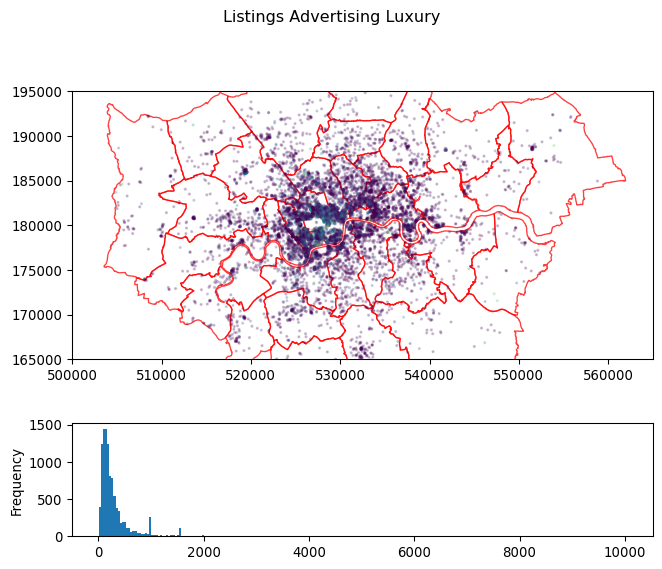

Your result should look similar to:

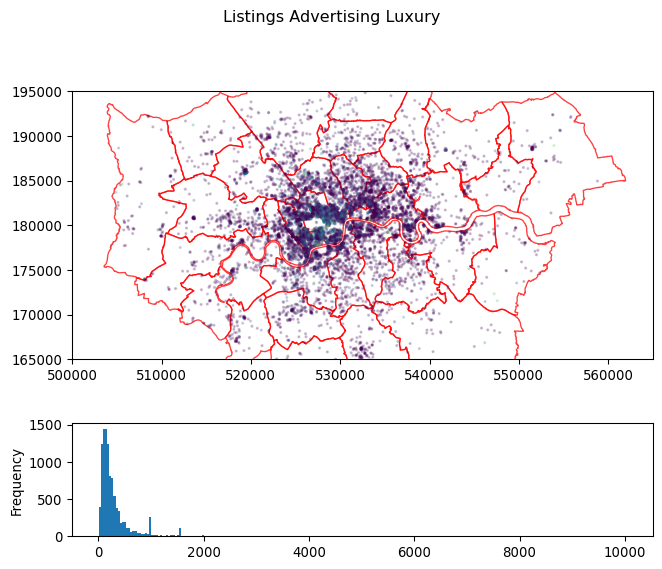

#### 4.1.4 Questions

-   What does `suptitle` do and how is it different from `title`? Could
    you use this as part of your plot-making process?
-   What does `tight_layout` do?

### 4.2 Budget Listings

> **Difficulty level: Easy, because you’ve worked out the hard bits
> already.**

#### 4.2.1 Create the Regular Expression

What words can you think of that might help you to spot affordable and
budget accommodation? Start with just a couple of words and then I would
encourage you to consider what *other* words might help to signal
‘affordability’… perhaps words like ‘cosy’ or ‘charming’ and then think
about how you could you add those to the regex?

*Hints*: this just builds on what you did above with one exception:

1.  I’d try adding word boundary markers to the regex (`\b`) where
    appropriate…

##### Question

``` python
gdf[
    gdf.description.str.contains(???, regex=True, flags=re.IGNORECASE)
].sample(5, random_state=42)[['description']]
```

##### Answer

``` python
gdf[
    gdf.description.str.contains(r'\b(?:affordable|budget|cheap|cosy)\b', 
    regex=True, flags=re.IGNORECASE)
].sample(5, random_state=42)[['description']]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|  | description |
|----|----|
| id |  |
| 10466073 | This is a charming little flat in crouch end, North London. It is located 10min from crouch end "village" which is packed with coffee shops, nice restaurants, shops etc... It is on a very quiet street and easy access to central London.\<br /\>\<br /... |
| 679538210387434496 | This trendy and spacious 3 bed house in Bow, is ideal for people who want to experience London but without all the hustle and bustle.\<br /\>\<br /\>It is situated in a peaceful area, where the vast open space of Victoria Park is within easy reach an... |
| 7560171 | The spacious house offers double bedroom with ensuit bathroom, a large kitchen and cosy living room.\<br /\>This luxurious and modern apartment is located 3 mins walking from London Bridge station; walking distance from many of Londons attractions\<... |
| 721518857445429120 | Kick back and relax in this calm, stylish one-bedroom, ground-floor flat in Leyton Village. There’s a contemporary kitchen and cosy living room with a sofa bed. The location puts you between Leyton and Leytonstone tube stations in a quiet street ... |
| 731014319309725184 | Beautiful 1 bedroom apartment in the heart of Peckham, only 10 minutes walk away from Peckham Rye station with direct trains to London Victoria (15mins), London Bridge (10mins) and Clapham Junction (16mins) - bringing the whole of London to your ... |

</div>

#### 4.2.2 Apply it to Select Data

##### Question

``` python
aff = gdf[gdf.description.str.contains(???, regex=True, flags=re.IGNORECASE)].copy()
print(f"There are {aff.shape[0]:,} rows flagged as 'affordable'.")
```

##### Answer

``` python
aff = gdf[gdf.description.str.contains(r'\b(?:affordable|budget|cheap|cosy)\b', 
          regex=True, flags=re.IGNORECASE)].copy()
print(f"There are {aff.shape[0]:,} rows flagged as 'affordable'.")
```

    There are 8,937 rows flagged as 'affordable'.

You should get `{python} f"{aff.shape[0]:,}"` rows.

#### 4.2.3 Plot the Data

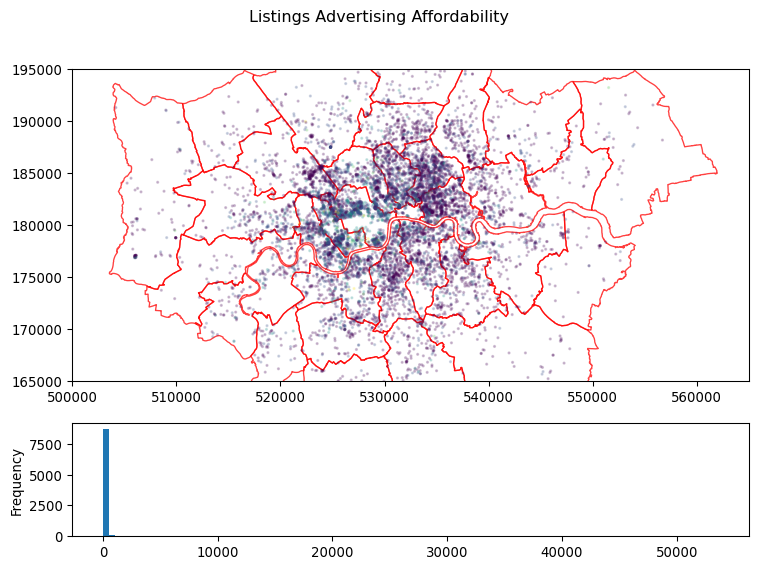

In [21]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.remove()

# The first plot
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
aff.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The second plot
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
aff.price.plot.hist(bins=100, ax=ax2)

plt.suptitle("Listings Advertising Affordability")
plt.tight_layout()
#plt.savefig("Affordable_Listings.png", dpi=150)

#### 4.2.4 Questions

-   Do you think that this is a *good* way to select affordable options?
-   Do you understand what `dpi` means and how `savefig` works?
-   Copy the code from above but modify it to constrain the histogram on
    a more limited distribution by *filtering* out the outliers *before*
    drawing the plot. I would copy the cell above to one just below here
    so that you keep a working copy available and can undo any changes
    that break things.

``` python

```

### 4.3 Near Bluespace

> **Difficulty level: Medium, because you’re still learning about
> regexes.**

Now see if you can work out a regular expression to find accommodation
that emphasises accessibility to the Thames and other ‘blue spaces’ as
part of the description? One thing you’ll need to tackle is that some
listings seem to say something about Thameslink and you wouldn’t want
those be returned as part of a regex looking for *rivers*. So by way of
a hint:

-   You probably need to think about the Thames, rivers, and water.
-   These will probably be *followed* by a qualifier like a ‘view’
    (e.g. Thames-view) or a front (e.g. water-front).
-   But you need to rule out things like “close the Thameslink station…”

#### 4.3.1 Create the regular Expression

##### Question

``` python
gdf[
    gdf.description.str.contains(???, regex=???, flags=???)
].sample(5, random_state=42)[['description']]
```

##### Answer

``` python
gdf[
    gdf.description.str.contains(r'(?:Thames|river|water|canals?)(?:-|\s+)(?: view|\s?front)\b', 
    regex=True, flags=re.IGNORECASE)
].sample(5, random_state=42)[['description']]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|  | description |
|----|----|
| id |  |
| 906924808902274560 | Brand new ultra spacious apartment just one minute walk from the Excel center and with great connections to anywhere in London.\<br /\>The area is full with cafés, supermarkets and restaurants just at your door step with lots of fun things to do li... |
| 600645213392859136 | Are you a woman?\<br /\>We offer a warm and friendly, Home from home, welcome to women travellers in our, peaceful and centrally located home.\<br /\>\<br /\> Excellent location in Zone1, with river ferry, trains, tube, and buses within a 5 minute wal... |
| 868117243960619264 | Just across the street from water front, near shadwell basin. View of Canary Wharf and the Shard on the big balcony\<br /\>\<br /\>7mins to shadwell overground and DLR. just 1 stop from Bank, Tower Bridge/Tower Hill, White Chapel (which connects to E... |
| 722937027420061056 | There’s no better way to experience the beauty of London City than by sleeping right in the heart of it. This Ensuite is within a 2-bed property. Ideally located at the river front to enjoy the mesmerising view of Canary Wharf.\<br /\>\<br /\>Within ... |
| 26748596 | Welcome to Sunbury Lane in Battersea :)\<br /\>\<br /\>My house is just off the river front allowing a large, safe space from which to explore the best of South London whilst also having a bus that runs you from our road into central in just 15 minut... |

</div>

#### 4.3.2 Apply it to the Select Data

##### Question

``` python
bluesp = gdf[
    (gdf.description.str.contains(???, regex=True, flags=re.IGNORECASE)) |
    (gdf.description.str.contains(???, regex=True, flags=re.IGNORECASE))
].copy()
print(f"Found {bluesp.shape[0]:,} rows.")
```

##### Answer

``` python
bluesp = gdf[
    (gdf.description.str.contains(r'(?:Thames|river|water|canals?)(?:-|\s+)(?:view|front)\b', regex=True, flags=re.IGNORECASE)) |
    (gdf.description.str.contains(r'(?:walk|close|near) to (?:Thames|river|water|canal)', regex=True, flags=re.IGNORECASE))
].copy()
print(f"Found {bluesp.shape[0]:,} rows.")
```

    Found 408 rows.

You should get `{python} f"{bluesp.shape[0]:,}"` rows.

#### 4.3.3 Plot the Data

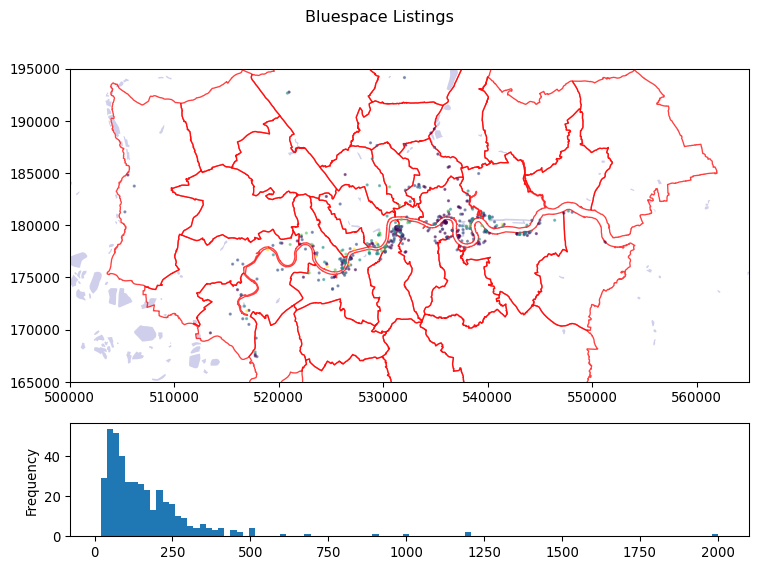

In [24]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.remove()

# The first plot
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
water.plot(edgecolor='none', facecolor=(.25, .25, .7, .25), ax=ax1)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
bluesp.plot(markersize=2, column='price', cmap='viridis', alpha=0.5, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The second plot
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
bluesp.price.plot.hist(bins=100, ax=ax2)

plt.suptitle("Bluespace Listings")
plt.tight_layout()
plt.show()

#### 4.3.4 Questions

-   How else might you select listings with a view of the Thames or
    other bluespaces?

## 5. Illustrative Text Cleaning

Now we’re going to step through the *parts* of the process that we apply
to clean and transform text. We’ll do this individually before using a
function to apply them *all at once*.

### 5.1 Downloading a Web Page

> **Difficulty Level: Low.**

There is plenty of good economic geography research being done using web
pages. Try using Google Scholar to look for work using the British
Library’s copy of the *Internet Archive*.

In [25]:
from urllib.request import urlopen, Request

# We need this so that the Bartlett web site 'knows'
# what kind of browser it is deasling with. Otherwise
# you get a Permission Error (403 Forbidden) because
# the site doesn't know what to do.
hdrs = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
}
url = 'https://www.ucl.ac.uk/bartlett/casa/about-0'

##### Question

``` python
# Notice that here we have to assemble a request and
# then 'open' it so that the request is properly issued
# to the web server. Normally, we'd just use `urlopen`, 
# but that doesn't give you the ability to set the headers.
request  = Request(url, None, hdrs) #The assembled request
response = urlopen(request)
html     = response.???.decode('utf-8') # The data you need

print(html[:1000])
```

##### Answer

``` python
# Notice that here we have to assemble a request and
# then 'open' it so that the request is properly issued
# to the web server. Normally, we'd just use `urlopen`, 
# but that doesn't give you the ability to set the headers.
request  = Request(url, None, hdrs) #The assembled request
response = urlopen(request)
html     = response.read().decode('utf-8') # The data you need

print(html[:1000])
```

    <!DOCTYPE html>
    <!--[if IE 7]>
    <html lang="en" class="lt-ie9 lt-ie8 no-js"> <![endif]-->
    <!--[if IE 8]>
    <html lang="en" class="lt-ie9 no-js"> <![endif]-->
    <!--[if gt IE 8]><!-->
    <html lang="en" class="no-js"> <!--<![endif]-->
    <head>
      <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
      <meta name="author" content="UCL"/>
      <meta property="og:profile_id" content="uclofficial"/>
      <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
    <link rel="shortcut icon" href="https://www.ucl.ac.uk/bartlett/casa/sites/all/themes/indigo/favicon.ico" type="image/vnd.microsoft.icon" />
    <meta name="description" content="The Centre for Advanced Spatial Analysis (CASA) is an interdisciplinary research institute focusing on the science of cities within The Bartlett Faculty of the Built Environment at UCL." />
    <link rel="canonical" href="https://www.ucl.ac.uk/bartlett/casa/about-0" />
    <meta name="ucl:faculty" content="Bartlett" />
    <meta name="ucl:org_unit" content="Cent

### 5.2 Removing HTML

> **Difficulty level: Moderate**
>
> Because what we’re doing will seem really strange and uses some
> previously unseen libraries that you’ll have to google.

*Hint*: you need to need to **get the text** out of the each returned
`<p>` and `<div>` element! I’d suggest also commenting this up since
there is a *lot* going on on some of these lines of code!

##### Question

``` python
cleaned = []

soup = BeautifulSoup(html)
body = soup.find('body')

for c in body.findChildren(recursive=False):
    if c.name in ['div','p'] and c.???.strip() != '': 
        # \xa0 is a non-breaking space in Unicode (&nbsp; in HTML)
        txt = [re.sub(r'(?:\u202f|\xa0|\u200b)',' ',x.strip()) for x in c.get_text(separator=" ").split('\n') if x.strip() != '']
        cleaned += txt

cleaned
```

##### Answer

``` python
cleaned = []

soup = BeautifulSoup(html)
body = soup.find('body')

for c in body.findChildren(recursive=False):
    if c.name in ['div','p'] and c.get_text().strip() != '':
        # \xa0 is a non-breaking space in Unicode (&nbsp; in HTML)
        txt = [re.sub(r'(?:\u202f|\xa0|\u200b)',' ',x.strip()) for x in c.get_text(separator=" ").split('\n') if x.strip() != '']
        cleaned += txt

cleaned
```

    ['UCL Home The Bartlett Centre for Advanced Spatial Analysis About',
     'About',
     'The Centre for Advanced Spatial Analysis (CASA) is an interdisciplinary research institute focusing on the science of cities within The Bartlett Faculty of the Built Environment at UCL.',
     'The Centre for Advanced Spatial Analysis (CASA) was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling and data science, sensing the urban environment, visualisation and computation.  Today, CASA’s research is still pushing boundaries to create better cities for everyone, both leading the intellectual agenda and working closely with government and industry partners to make real-world impact.  Our teaching reflects this, making the most of our cutting-edge research, tools, new forms of data, and long-standing non-academic partnerships to train the next generation of urban scientists with the skills and ideas they’ll need to have an impact in industry, government, academia, and the third sector.  The CASA community is closely connected, but strongly interdisciplinary. We bring together people from around the world with a unique variety of backgrounds – including physicists, planners, geographers, economists, data scientists, architects, mathematicians and computer scientists – united by our mission to tackle the biggest challenges facing cities and societies around the world.  We work across multiple scales: from the hyper-local environment of the low-powered sensor all the way up to satellite remote sensing of whole countries and regions.  Studying at CASA brings lifelong value, with our students poised to take on leadership and integration roles at the forefront of urban and spatial data science.  By studying with us you will become part of our active and engaged alumni community, with access to job listings, networking and social activities, as well as continued contact with our outstanding teachers and researchers.   Location The UCL Centre for Advanced Spatial Analysis is located at 90 Tottenham Court Road, London, W1T 4TJ.',
     'View Map',
     'Contact Address: UCL Centre for Advanced Spatial Analysis First Floor, 90 Tottenham Court Road London W1T 4TJ Telephone:  +44 (0)20 3108 3877 Email:   casa@ucl.ac.uk',
     'Tweets by CASAUCL']

### 5.3 Lower Case

> **Difficulty Level: Low.**

##### Question

``` python
lower = [c.???() for ??? in cleaned]
lower
```

##### Answer

``` python
lower = [s.lower() for s in cleaned]
lower
```

    ['ucl home the bartlett centre for advanced spatial analysis about',
     'about',
     'the centre for advanced spatial analysis (casa) is an interdisciplinary research institute focusing on the science of cities within the bartlett faculty of the built environment at ucl.',
     'the centre for advanced spatial analysis (casa) was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling and data science, sensing the urban environment, visualisation and computation.  today, casa’s research is still pushing boundaries to create better cities for everyone, both leading the intellectual agenda and working closely with government and industry partners to make real-world impact.  our teaching reflects this, making the most of our cutting-edge research, tools, new forms of data, and long-standing non-academic partnerships to train the next generation of urban scientists with the skills and ideas they’ll need to have an impact in industry, government, academia, and the third sector.  the casa community is closely connected, but strongly interdisciplinary. we bring together people from around the world with a unique variety of backgrounds – including physicists, planners, geographers, economists, data scientists, architects, mathematicians and computer scientists – united by our mission to tackle the biggest challenges facing cities and societies around the world.  we work across multiple scales: from the hyper-local environment of the low-powered sensor all the way up to satellite remote sensing of whole countries and regions.  studying at casa brings lifelong value, with our students poised to take on leadership and integration roles at the forefront of urban and spatial data science.  by studying with us you will become part of our active and engaged alumni community, with access to job listings, networking and social activities, as well as continued contact with our outstanding teachers and researchers.   location the ucl centre for advanced spatial analysis is located at 90 tottenham court road, london, w1t 4tj.',
     'view map',
     'contact address: ucl centre for advanced spatial analysis first floor, 90 tottenham court road london w1t 4tj telephone:  +44 (0)20 3108 3877 email:   casa@ucl.ac.uk',
     'tweets by casaucl']

### 5.4 Stripping ‘Punctuation’

> **Difficulty level: Hard**
>
> This is because you need to understand: 1) why we’re *compiling* the
> regular expression and how to use character classes; and 2) how the
> NLTK tokenizer differs in approach to the regex.

#### 5.4.1 Regular Expression Approach

We want to clear out punctuation using a regex that takes advantage of
the `[...]` (character class) syntax. The really tricky part is
remembering how to specify the ‘punctuation’ when some of that
punctuation has ‘special’ meanings in a regular expression context. For
instance, `.` means ‘any character’, while `[` and `]` mean ‘character
class’. So this is another *escaping* problem and it works the *same*
way it did when we were dealing with the Terminal…

*Hints*: some other factors…

1.  You will want to match more than one piece of punctuation at a time,
    so I’d suggest add a `+` to your pattern.
2.  You will need to look into *metacharacters* for creating a kind of
    ‘any of the characters *in this class*’ bag of possible matches.

##### Question

``` python
pattern = re.compile(r'[???]+')
print(pattern)
```

##### Answer

``` python
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
print(pattern)
```

    re.compile('[,\\.!\\-><=\\(\\)\\[\\]\\/&\\\'\\"’;\\+\\–\\—]+')

#### 5.4.2 Tokenizer

The other way to do this, which is probably *easier* but produces more
complex output, is to draw on the tokenizers [already provided by
NLTK](https://www.nltk.org/api/nltk.tokenize.html). For our purposes
`word_tokenize` is probably fine, but depending on your needs there are
other options and you can also write your own.

In [30]:
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
print(word_tokenize)

<function word_tokenize at 0x155eae160>

[nltk_data] Downloading package punkt to /Users/jreades/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jreades/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

#### 5.4.3 Compare

Look at how these outputs differ in subtle ways:

In [31]:
subbed = []
tokens = []
for l in lower:
    subbed.append(re.sub(pattern, ' ', l))
    tokens.append(word_tokenize(l))

for s in subbed:
    as_markdown("Substituted", s)

for t in tokens:
    as_markdown("Tokenised", t)

### 5.5 Stopword Removal

> **Difficulty Level: Moderate**
>
> You need to remember how list comprehensions work to use the
> `stopword_list`.

In [32]:
stopword_list = set(stopwords.words('english'))
print(stopword_list)

{'only', 'mustn', 'any', 'before', 'just', "you'd", 'when', 'she', 're', 'yours', 'himself', 'does', 'hadn', 'this', 'your', 'there', 'at', 'nor', 'some', 'can', 'why', 'or', 'to', 'against', 'don', 'same', 'during', 'am', 'haven', 'too', "isn't", "mightn't", 'because', 'did', 'so', 'my', 'those', 'doing', 'where', 'both', 'mightn', "shouldn't", 'for', 'y', 'doesn', "should've", 'on', 'under', 'needn', 'me', "you're", 'few', "haven't", 'are', 'most', "needn't", 'by', 'about', 'than', 'below', "weren't", 'been', 'have', 'what', "didn't", 'do', "shan't", 'is', 'in', 'out', 'ma', 'hasn', 'we', 'again', 'weren', "hasn't", 'were', 'with', 'wasn', 'he', "it's", 'not', 'herself', 'and', 'through', 'isn', 'such', 'which', 'ain', 'these', 'be', 'very', "aren't", 'his', "wouldn't", 'couldn', 'ours', 'as', "hadn't", 'an', 've', 'between', "couldn't", 'shouldn', 'then', 'hers', 'after', 'from', 'theirs', "you'll", "wasn't", 'up', 'wouldn', 'you', 'its', 'yourselves', 'each', 'here', 'aren', 'our',

##### Question

``` python
stopped = []
for p in tokens[2:4]: # <-- why do I just take these items from the list?
    stopped.append([x for x in p if x not in ??? and len(x) > 1])

for s in stopped:
    as_markdown("Line", s)
```

##### Answer

``` python
stopped = []
for p in tokens[2:4]: # <-- why do I just take these items from the list?
    stopped.append([x for x in p if x not in stopword_list and len(x) > 1])

for s in stopped:
    as_markdown("Line", s)
```

###### 5.5.0.0.1 Line

> \[‘centre’, ‘advanced’, ‘spatial’, ‘analysis’, ‘casa’,
> ‘interdisciplinary’, ‘research’, ‘institute’, ‘focusing’, ‘science’,
> ‘cities’, ‘within’, ‘bartlett’, ‘faculty’, ‘built’, ‘environment’,
> ‘ucl’\]

###### 5.5.0.0.2 Line

> \[‘centre’, ‘advanced’, ‘spatial’, ‘analysis’, ‘casa’, ‘established’,
> ‘1995’, ‘lead’, ‘development’, ‘science’, ‘cities’, ‘drawing’, ‘upon’,
> ‘methods’, ‘ideas’, ‘modelling’, ‘data’, ‘science’, ‘sensing’,
> ‘urban’, ‘environment’, ‘visualisation’, ‘computation’, ‘today’,
> ‘casa’, ‘research’, ‘still’, ‘pushing’, ‘boundaries’, ‘create’,
> ‘better’, ‘cities’, ‘everyone’, ‘leading’, ‘intellectual’, ‘agenda’,
> ‘working’, ‘closely’, ‘government’, ‘industry’, ‘partners’, ‘make’,
> ‘real-world’, ‘impact’, ‘teaching’, ‘reflects’, ‘making’,
> ‘cutting-edge’, ‘research’, ‘tools’, ‘new’, ‘forms’, ‘data’,
> ‘long-standing’, ‘non-academic’, ‘partnerships’, ‘train’, ‘next’,
> ‘generation’, ‘urban’, ‘scientists’, ‘skills’, ‘ideas’, ‘need’,
> ‘impact’, ‘industry’, ‘government’, ‘academia’, ‘third’, ‘sector’,
> ‘casa’, ‘community’, ‘closely’, ‘connected’, ‘strongly’,
> ‘interdisciplinary’, ‘bring’, ‘together’, ‘people’, ‘around’, ‘world’,
> ‘unique’, ‘variety’, ‘backgrounds’, ‘including’, ‘physicists’,
> ‘planners’, ‘geographers’, ‘economists’, ‘data’, ‘scientists’,
> ‘architects’, ‘mathematicians’, ‘computer’, ‘scientists’, ‘united’,
> ‘mission’, ‘tackle’, ‘biggest’, ‘challenges’, ‘facing’, ‘cities’,
> ‘societies’, ‘around’, ‘world’, ‘work’, ‘across’, ‘multiple’,
> ‘scales’, ‘hyper-local’, ‘environment’, ‘low-powered’, ‘sensor’,
> ‘way’, ‘satellite’, ‘remote’, ‘sensing’, ‘whole’, ‘countries’,
> ‘regions’, ‘studying’, ‘casa’, ‘brings’, ‘lifelong’, ‘value’,
> ‘students’, ‘poised’, ‘take’, ‘leadership’, ‘integration’, ‘roles’,
> ‘forefront’, ‘urban’, ‘spatial’, ‘data’, ‘science’, ‘studying’, ‘us’,
> ‘become’, ‘part’, ‘active’, ‘engaged’, ‘alumni’, ‘community’,
> ‘access’, ‘job’, ‘listings’, ‘networking’, ‘social’, ‘activities’,
> ‘well’, ‘continued’, ‘contact’, ‘outstanding’, ‘teachers’,
> ‘researchers’, ‘location’, ‘ucl’, ‘centre’, ‘advanced’, ‘spatial’,
> ‘analysis’, ‘located’, ‘90’, ‘tottenham’, ‘court’, ‘road’, ‘london’,
> ‘w1t’, ‘4tj’\]

### 5.6 Lemmatisation vs Stemming

> **Difficulty level: Low.**

In [34]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

In [35]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('monkeys'))
print(lemmatizer.lemmatize('cities'))
print(lemmatizer.lemmatize('complexity'))
print(lemmatizer.lemmatize('Reades'))

monkey
city
complexity
Reades

In [36]:
stemmer = PorterStemmer()
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read

In [37]:
stemmer = SnowballStemmer(language='english')
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read

In [38]:
lemmatizer = WordNetLemmatizer()
lemmas  = []
stemmed = []

# This would be better if we passed in a PoS (Part of Speech) tag as well,
# but processing text for parts of speech is *expensive* and for the purposes
# of this tutorial, not necessary.
for s in stopped:
    lemmas.append([lemmatizer.lemmatize(x) for x in s])

for s in stopped:
    stemmed.append([stemmer.stem(x) for x in s])

for l in lemmas:
    as_markdown('Lemmatised',l)

for s in stemmed:
    as_markdown('Stemmed',s)

In [39]:
# What are we doing here?
for ix, p in enumerate(stopped):
    stopped_set = set(stopped[ix])
    lemma_set   = set(lemmas[ix])
    print(sorted(stopped_set.symmetric_difference(lemma_set)))

['cities', 'city']
['activities', 'activity', 'alumni', 'alumnus', 'architect', 'architects', 'background', 'backgrounds', 'boundaries', 'boundary', 'challenge', 'challenges', 'cities', 'city', 'countries', 'country', 'economist', 'economists', 'form', 'forms', 'geographer', 'geographers', 'idea', 'ideas', 'listing', 'listings', 'mathematician', 'mathematicians', 'method', 'methods', 'partner', 'partners', 'partnership', 'partnerships', 'physicist', 'physicists', 'planner', 'planners', 'region', 'regions', 'researcher', 'researchers', 'role', 'roles', 'scale', 'scales', 'scientist', 'scientists', 'skill', 'skills', 'societies', 'society', 'student', 'students', 'teacher', 'teachers', 'tool', 'tools', 'u', 'us']

## 6. Applying Normalisation

The above approach is fairly hard going since you need to loop through
every list element applying these changes one at a time. Instead, we
could convert the column to a corpus (or use pandas `apply`) together
with a function imported from a library to do the work.

### 6.1 Downloading the Custom Module

> **Difficulty level: Low.**

This custom module is not perfect, but it gets the job done… mostly and
has some additional features that you could play around with for a final
project (e.g. `detect_entities` and `detect_acronyms`).

In [40]:
import urllib.request
host  = 'https://orca.casa.ucl.ac.uk'
turl  = f'{host}/~jreades/__textual__.py'
tdirs = os.path.join('textual')
tpath = os.path.join(tdirs,'__init__.py')

if not os.path.exists(tpath):
    os.makedirs(tdirs, exist_ok=True)
    urllib.request.urlretrieve(turl, tpath)

### 6.2 Importing the Custom Module

> **Difficulty Level: Low.**
>
> But only because you didn’t have to write the module! However, the
> questions could be hard…

In a Jupyter notebook, this code allows us to edit and reload the
library dynamically:

``` python
%load_ext autoreload
%autoreload 2
```

Now let’s import it.

In [41]:
from textual import *

All NLTK libraries installed...

In [42]:
as_markdown('Input', cleaned)

In [43]:
as_markdown('Normalised', [normalise_document(x, remove_digits=True) for x in cleaned])

In [44]:
help(normalise_document)

Help on function normalise_document in module textual:

normalise_document(doc: str, html_stripping=True, contraction_expansion=True, accented_char_removal=True, text_lower_case=True, text_lemmatization=True, special_char_removal=False, punctuation_removal=True, keep_sentences=True, stopword_removal=True, remove_digits=False, infer_numbers=True, shortest_word=3) -> str
    Apply all of the functions above to a document using their
    default values so as to demonstrate the NLP process.

    doc: a document to clean.


#### 6.2.1 Questions

Let’s assume that you want to analyse web page content…

-   Based on the above output, what stopwords do you think are missing?
-   Based on the above output, what should be removed but isn’t?
-   Based on the above output, how do you think a computer can work with
    this text?

> **Stop!**
>
> Beyond this point, we are moving into Natural Language Processing. If
> you are already struggling with regular expressions, I would recommend
> *stopping here*. You can come back to revisit the NLP components and
> creation of word clouds later.

## 7. Revenons à Nos Moutons

Now that you’ve seen how the steps are applied to a ‘random’ HTML
document, let’s get back to the problem at hand (revenons à nos moutons
== let’s get back to our sheep).

### 7.1 Process the Selected Listings

> **Difficulty level: Low, but you’ll need to be patient!**

Notice the use of `%%time` here – this will tell you how long each block
of code takes to complete. It’s a really useful technique for reminding
*yourself* and others of how long something might take to run. I find
that with NLP this is particularly important since you have to do a
*lot* of processing on each document in order to normalise it.

> **Tip**
>
> Notice how we can change the default parameters for
> `normalise_document` even when using `apply`, but that the syntax is
> different. So whereas we’d use
> `normalise_document(doc, remove_digits=True)` if calling the function
> directly, here it’s `.apply(normalise_document, remove_digits=True)`!

##### Question

``` python
%%time 
# I get about 1 minute on a M2 Mac
lux['description_norm'] = lux.???.apply(???, remove_digits=True)
```

``` python
%%time 
# I get about 1 minute on a M2 Mac
aff['description_norm'] = aff.???.apply(???, remove_digits=True)
```

``` python
%%time  
# I get about 2 seconds on a M2 Mac
bluesp['description_norm'] = bluesp.???.apply(???, remove_digits=True)
```

##### Answer

``` python
%%time
# I get about 1 minute on a M2 Mac
lux['description_norm'] = lux.description.apply(normalise_document, remove_digits=True)
```

    /Users/jreades/Documents/git/fsds/practicals/textual/__init__.py:606: MarkupResemblesLocatorWarning:

    The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

    CPU times: user 43.9 s, sys: 469 ms, total: 44.3 s
    Wall time: 44.3 s

``` python
%%time
# I get about 1 minute on a M2 Mac
aff['description_norm'] = aff.description.apply(normalise_document, remove_digits=True)
```

    /Users/jreades/Documents/git/fsds/practicals/textual/__init__.py:606: MarkupResemblesLocatorWarning:

    The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

    CPU times: user 36.9 s, sys: 530 ms, total: 37.5 s
    Wall time: 37.5 s

``` python
%%time
# I get about 1 seconds on a M2 Mac
bluesp['description_norm'] = bluesp.description.apply(normalise_document, remove_digits=True)
```

    CPU times: user 1.61 s, sys: 28.6 ms, total: 1.64 s
    Wall time: 1.64 s

### 7.2 Select and Tokenise

> **Difficulty level: Low, except for the double list-comprehension.**

#### 7.2.1 Select and Extract Corpus

See useful tutorial
[here](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275).
Although we shouldn’t have any empty descriptions, by the time we’ve
finished normalising the textual data we may have *created* some empty
values and we need to ensure that we don’t accidentally pass a NaN to
the vectorisers and frequency distribution functions.

In [48]:
srcdf = bluesp 

> **Coding Tip**
>
> Notice how you only need to change the value of the variable here to
> try any of the different selections we did above? This is a simple
> kind of parameterisation somewhere between a function and hard-coding
> everything.

In [49]:
corpus = srcdf.description_norm.fillna(' ').values
print(corpus[0:3])

['house garden close thames river . walk  private road river nearby .  district line underground . walk . direct access central london  near gardens . kids playground walk distance along thames path . space residential neighborhood  english corporate expat family . house culdesac private road river thames . river foot away . walking distance subway . central london underground   district line . gardens stop walk zone . addition  overground stratford also stop gardens underground station . gardens stop walk .  overland railway station bridge . walk . take waterloo railway station minute . bicycle follow towpath hammersmith bridge continue putney bridge . lastly  several stree'
 'space appartment upper floor modernised secure building near canary wharf  fantastic view river thames london . offer home home experience  light breafast fresh juice coffee . double room plenty storage  fresh towels linen . shared bathroom step shower  hairdryer essentials . wifi service . appartment  minutes w

#### 7.2.2 Tokenise

There are different forms of tokenisation and different algorithms will
expect differing inputs. Here are two:

In [50]:
sentences = [nltk.sent_tokenize(text) for text in corpus]
words     = [[nltk.tokenize.word_tokenize(sentence) 
                  for sentence in nltk.sent_tokenize(text)] 
                  for text in corpus]

Notice how this has turned every sentence into an array and each
document into an array of arrays:

In [51]:
print(f"Sentences 0: {sentences[0]}")
print()
print(f"Words 0: {words[0]}")

Sentences 0: ['house garden close thames river .', 'walk  private road river nearby .', 'district line underground .', 'walk .', 'direct access central london  near gardens .', 'kids playground walk distance along thames path .', 'space residential neighborhood  english corporate expat family .', 'house culdesac private road river thames .', 'river foot away .', 'walking distance subway .', 'central london underground   district line .', 'gardens stop walk zone .', 'addition  overground stratford also stop gardens underground station .', 'gardens stop walk .', 'overland railway station bridge .', 'walk .', 'take waterloo railway station minute .', 'bicycle follow towpath hammersmith bridge continue putney bridge .', 'lastly  several stree']

Words 0: [['house', 'garden', 'close', 'thames', 'river', '.'], ['walk', 'private', 'road', 'river', 'nearby', '.'], ['district', 'line', 'underground', '.'], ['walk', '.'], ['direct', 'access', 'central', 'london', 'near', 'gardens', '.'], ['kids'

### 7.3 Frequencies and Ngrams

> **Difficulty level: Moderate.**

One new thing you’ll see here is the `ngram`: ngrams are ‘simply’ pairs,
or triplets, or quadruplets of words. You may come across the terms
unigram (`ngram(1,1)`), bigram (`ngram(2,2)`), trigram (`ngram(3,3)`)…
typically, you will rarely find anything beyond trigrams, and these
present real issues for text2vec algorithms because the embedding for
`geographical`, `information`, and `systems` is *not* the same as for
`geographical information systetms`.

#### 7.3.1 Build Frequency Distribution

Build counts for ngram range 1..3:

In [52]:
fcounts = dict()

# Here we replace all full-stops... can you think why we might do this?
data = nltk.tokenize.word_tokenize(' '.join([text.replace('.','') for text in corpus]))

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one note this: https://stackoverflow.com/a/52193485/4041902
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

<FreqDist with 2692 samples and 26245 outcomes>
<FreqDist with 14173 samples and 26244 outcomes>
<FreqDist with 19540 samples and 26243 outcomes>

#### 7.3.2 Output Top-n Ngrams

And output the most common ones for each ngram range:

In [53]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))
    print()

           Ngram Size 1
walk                594
room                472
london              469
river               418
bedroom             412
space               391
minute              382
apartment           373
station             307
flat                303

                 Ngram Size 2
minute  walk              252
river   thames            138
        view              138
living  room              134
canary  wharf             112
guest   access            110
central london            107
fully   equip              76
equip   kitchen            71
thames  river              65

                        Ngram Size 3
fully  equip  kitchen             68
walk   river  thames              37
close  river  thames              35
walk   thames river               27
minute walk   river               23
open   plan   kitchen             20
thames river  view                20
sofa   living room                19
within walk   distance            19
open   plan   live                

#### 7.3.3 Questions

-   Can you think why we don’t care about punctuation for frequency
    distributions and n-grams?
-   Do you understand what n-grams *are*?

### 7.4 Count Vectoriser

> **Difficulty level: Low, but the output needs some thought!**

This is a big foray into sklearn (sci-kit learn) which is the main
machine learning and clustering module for Python. For processing text
we use *vectorisers* to convert terms to a vector representation. We’re
doing this on the smallest of the derived data sets because these
processes can take a while to run and generate *huge* matrices
(remember: one row and one column for each term!).

#### 7.4.1 Fit the Vectoriser

In [54]:
cvectorizer = CountVectorizer(ngram_range=(1,3))
cvectorizer.fit(corpus)

CountVectorizer(ngram_range=(1, 3)) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   CountVectorizer ? Documentation for CountVectorizer i Fitted CountVectorizer(ngram_range=(1, 3))

#### 7.4.2 Brief Demonstration

Find the number associated with a word in the vocabulary and how many
times it occurs in the original corpus:

In [55]:
term = 'stratford'
pd.options.display.max_colwidth=750
# Find the vocabulary mapping for the term
print(f"Vocabulary mapping for {term} is {cvectorizer.vocabulary_[term]}")
# How many times is it in the data
print(f"Found {srcdf.description_norm.str.contains(term).sum():,} rows containing {term}")
# Print the descriptions containing the term
for x in srcdf[srcdf.description_norm.str.contains(term)].description_norm:
    as_markdown('Stratford',x)

Vocabulary mapping for stratford is 29373
Found 10 rows containing stratford

#### 7.4.3 Transform the Corpus

You can only *tranform* the entire corpus *after* the vectoriser has
been fitted. There is an option to `fit_transform` in one go, but I
wanted to demonstrate a few things here and some vectorisers are don’t
support the one-shot fit-and-transform approach. **Note the type of the
transformed corpus**:

In [56]:
cvtcorpus = cvectorizer.transform(corpus)
cvtcorpus # cvtcorpus for count-vectorised transformed corpus

<408x35278 sparse matrix of type '<class 'numpy.int64'>'
    with 71420 stored elements in Compressed Sparse Row format>

#### 7.4.4 Single Document

Here is the **first** document from the corpus:

In [57]:
doc_df = pd.DataFrame(cvtcorpus[0].T.todense(), 
                      index=cvectorizer.get_feature_names_out(), columns=["Counts"]
                     ).sort_values('Counts', ascending=False)
doc_df.head(10)

#### 7.4.5 Transformed Corpus

In [58]:
cvdf = pd.DataFrame(data=cvtcorpus.toarray(),
                        columns=cvectorizer.get_feature_names_out())
print(f"Raw count vectorised data frame has {cvdf.shape[0]:,} rows and {cvdf.shape[1]:,} columns.")
cvdf.iloc[0:5,0:10]

Raw count vectorised data frame has 408 rows and 35,278 columns.

#### 7.4.6 Filter Low-Frequency Words

These are likely to be artefacts of text-cleaning or human input error.
As well, if we’re trying to look across an entire corpus then we might
not want to retain words that only appear in a couple of documents.

Let’s start by getting the *column* sums:

In [59]:
sums = cvdf.sum(axis=0)
print(f"There are {len(sums):,} terms in the data set.")
sums.head()

There are 35,278 terms in the data set.

aaathe                    1
aaathe apartment          1
aaathe apartment quiet    1
aand                      1
aand comfy                1
dtype: int64

Remove columns (i.e. terms) appearing in less than 1% of documents. You
can do this by thinking about what the shape of the data frame means
(rows and/or columns) and how you’d get 1% of that!

##### Question

``` python
filter_terms = sums >= cvdf.shape[0] * ???
```

##### Answer

``` python
filter_terms = sums >= cvdf.shape[0] * 0.01
```

Now see how we can use this to strip out the columns corresponding to
low-frequency terms:

In [61]:
fcvdf = cvdf.drop(columns=cvdf.columns[~filter_terms].values)
print(f"Filtered count vectorised data frame has {fcvdf.shape[0]:,} rows and {fcvdf.shape[1]:,} columns.")
fcvdf.iloc[0:5,0:10]

Filtered count vectorised data frame has 408 rows and 2,043 columns.

In [62]:
fcvdf.sum(axis=0)

able                         8
access                     242
access access                7
access bathroom              5
access central               8
                          ... 
zone comfortable cosy        7
zone near                    5
zone near underground        5
zone recently               10
zone recently refurbish     10
Length: 2043, dtype: int64

We’re going to pick this up again in Task 7.

#### 7.4.7 Questions

-   Can you explain what `doc_df` contains?
-   What does `cvdf` contain? Explain the rows and columns.
-   What is the function of `filter_terms`?

### 7.5 TF/IDF Vectoriser

> **Difficulty level: Moderate**
>
> But only if you want to understand how `max_df` and `min_df` work!

#### 7.5.1 Fit and Transform

In [63]:
tfvectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), 
                               max_df=0.75, min_df=0.01) # <-- these matter!
tftcorpus    = tfvectorizer.fit_transform(corpus) # TF-transformed corpus

#### 7.5.2 Single Document

In [64]:
doc_df = pd.DataFrame(tftcorpus[0].T.todense(), index=tfvectorizer.get_feature_names_out(), columns=["Weights"])
doc_df.sort_values('Weights', ascending=False).head(10)

#### 7.5.3 Transformed Corpus

In [65]:
tfidf = pd.DataFrame(data=tftcorpus.toarray(),
                        columns=tfvectorizer.get_feature_names_out())
print(f"TF/IDF data frame has {tfidf.shape[0]:,} rows and {tfidf.shape[1]:,} columns.")
tfidf.head()

TF/IDF data frame has 408 rows and 1,911 columns.

5 rows × 1911 columns

#### 7.5.4 Questions

-   What does the TF/IDF score *represent*?
-   What is the role of `max_df` and `min_df`?

## 8. Word Clouds

### 8.1 For Counts

> **Difficulty level: Easy!**

In [66]:
fcvdf.sum().sort_values(ascending=False)

walk                      595
room                      472
london                    471
river                     418
bedroom                   412
                         ... 
chic                        5
term                        5
choice                      5
teddington                  5
london aquarium minute      5
Length: 2043, dtype: int64

In [67]:
ff = 'RobotoMono-VariableFont_wght.ttf'
dp = '/home/jovyan/.local/share/fonts/'
tp = os.path.join(os.path.expanduser('~'),'Library','Fonts')
if os.path.exists(tp):
    fp = os.path.join(tp,ff)
else:
    fp = os.path.join(dp,ff)

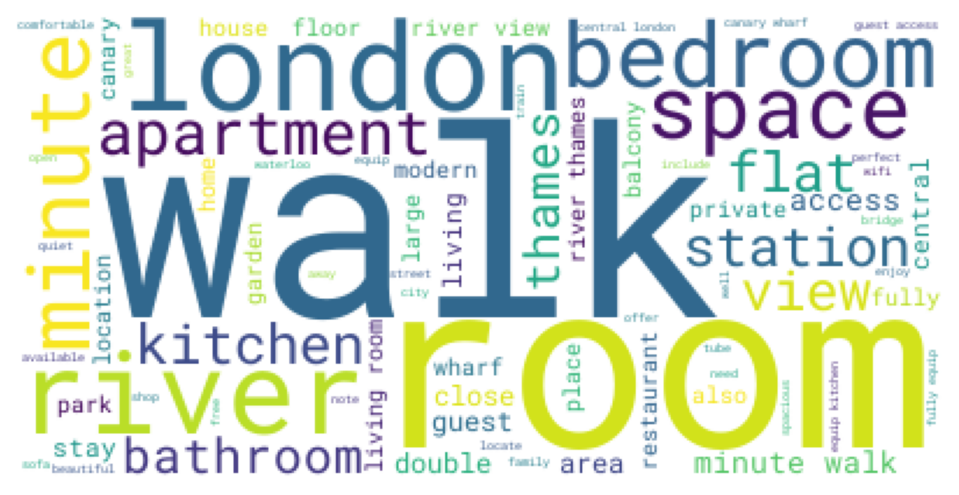

In [68]:
f,ax = plt.subplots(1,1,figsize=(8, 8))
plt.gcf().set_dpi(150)
Cloud = WordCloud(
    background_color="white", 
    max_words=75,
    font_path=fp
).generate_from_frequencies(fcvdf.sum())
ax.imshow(Cloud) 
ax.axis("off");
#plt.savefig("Wordcloud 1.png")

### 8.2 For TF/IDF Weighting

> **Difficulty level: Low, but you’ll need to be patient!**

In [69]:
tfidf.sum().sort_values(ascending=False)

walk                     23.037285
room                     19.135852
london                   18.744519
minute                   18.650909
apartment                18.082855
                           ...    
station apartment one     0.401426
station also close        0.401426
apartment one benefit     0.401426
apartment one             0.401426
also close station        0.401426
Length: 1911, dtype: float64

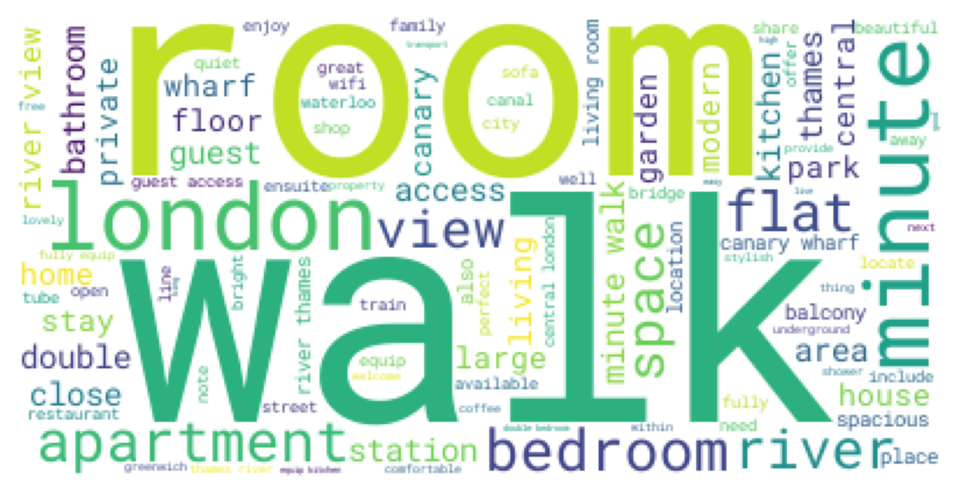

In [70]:
f,ax = plt.subplots(1,1,figsize=(8, 8))
plt.gcf().set_dpi(150)
Cloud = WordCloud(
    background_color="white", 
    max_words=100,
    font_path=fp
).generate_from_frequencies(tfidf.sum())
ax.imshow(Cloud) 
ax.axis("off");
#plt.savefig("Wordcloud 2.png")

#### 8.2.1 Questions

-   What does the `sum` represent for the count vectoriser?
-   What does the `sum` represent for the TF/IDF vectoriser?

## 9. Latent Dirchlet Allocation

> **Tip**
>
> I would give this a *low* priority. It’s a commonly-used method, but
> on small data sets it really isn’t much use and I’ve found its answers
> to be… unclear… even on large data sets.

Adapted from [this
post](https://stackabuse.com/python-for-nlp-topic-modeling/) on doing
LDA using sklearn. Most other examples use the `gensim` library.

In [71]:
# Notice change to ngram range 
# (try 1,1 and 1,2 for other options)
vectorizer = CountVectorizer(ngram_range=(1,2))

### 9.1 Calculate Topics

In [72]:
vectorizer.fit(corpus) 
tcorpus = vectorizer.transform(corpus) # tcorpus for transformed corpus

LDA = LatentDirichletAllocation(n_components=3, random_state=42) # Might want to experiment with n_components too
LDA.fit(tcorpus)

LatentDirichletAllocation(n_components=3, random_state=42) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   LatentDirichletAllocation ? Documentation for LatentDirichletAllocation i Fitted LatentDirichletAllocation(n_components=3, random_state=42)

In [73]:
first_topic = LDA.components_[0]
top_words = first_topic.argsort()[-25:]

for i in top_words:
    print(vectorizer.get_feature_names_out()[i])

river thames
modern
area
wharf
flat
access
bathroom
guest
house
minute
private
kitchen
large
thames
living
view
station
floor
bedroom
apartment
walk
london
river
room
space

In [74]:
for i,topic in enumerate(LDA.components_):
    as_markdown(f'Top 10 words for topic #{i}', ', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-25:]]))

### 9.2 Maximum Likelihood Topic

In [75]:
topic_values = LDA.transform(tcorpus)
topic_values.shape

(408, 3)

In [76]:
pd.options.display.max_colwidth=20
srcdf['Topic'] = topic_values.argmax(axis=1)
srcdf.head()

In [77]:
pd.options.display.max_colwidth=75
srcdf[srcdf.Topic==1].description_norm.head(10)

id
36299      house garden close thames river . walk  private road river nearby .  di...
827436     brand riverside apartment greenwich peninsula . perfect explore london ...
1611173    mint walk thames river  mint tower bridge  mint greenwich bus mint walk...
1910741    bright  spacious chill bedroom cosy apartment level friendly quiet bloc...
5284354    fabulous bathshower flat modern development east putney  london literal...
5498948    large double room river view available large spacious townhouse hampton...
6479011    private quiet bright  large double room ensuite bathroom . location stu...
6619558    bright  airy bedroom  ground floor apartment quiet street . modernly fu...
7495122    perfect claphambattersea modern decor . brand kitchenbathroom minute wa...
8352150    room front house overlook balcony  road river . bright sunny house view...
Name: description_norm, dtype: object

In [78]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)
topic_corpus = vectorizer.fit_transform(srcdf[srcdf.Topic==1].description.values) # tcorpus for transformed corpus

In [79]:
topicdf = pd.DataFrame(data=topic_corpus.toarray(),
                        columns=vectorizer.get_feature_names_out())

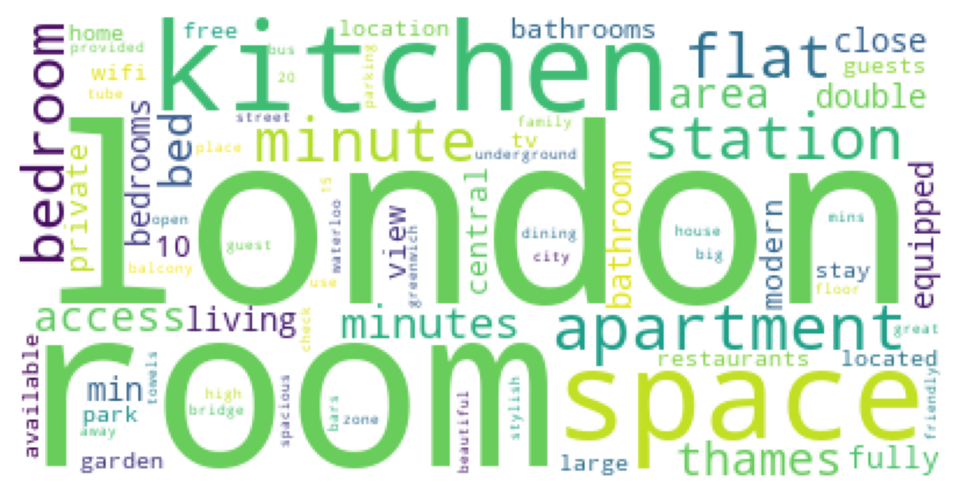

In [80]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.gcf().set_dpi(150)
Cloud = WordCloud(
            background_color="white", 
            max_words=75).generate_from_frequencies(topicdf.sum())
ax.imshow(Cloud) 
ax.axis("off");
# plt.savefig('Wordcloud 3.png')

## 10. Word2Vec

> **Tip**
>
> This algorithm works almost like magic. You should play with the
> configuration parameters and see how it changes your results.

### 10.1 Configure

In [81]:
from gensim.models.word2vec import Word2Vec

In [82]:
dims = 100
print(f"You've chosen {dims} dimensions.")

window = 3
print(f"You've chosen a window of size {window}.")

min_v_freq  = 0.005 # Don't keep words appearing less than 0.5% frequency
min_v_count = math.ceil(min_v_freq * srcdf.shape[0])
print(f"With a minimum frequency of {min_v_freq} and {srcdf.shape[0]:,} documents, minimum vocab frequency is {min_v_count:,}.")

You've chosen 100 dimensions.
You've chosen a window of size 3.
With a minimum frequency of 0.005 and 408 documents, minimum vocab frequency is 3.

### 10.2 Train

In [83]:
%%time 

corpus      = srcdf.description_norm.fillna(' ').values
#corpus_sent = [nltk.sent_tokenize(text) for text in corpus] # <-- with more formal writing this would work well
corpus_sent = [d.replace('.',' ').split(' ') for d in corpus] # <-- deals better with many short sentences though context may end up... weird
model       = Word2Vec(sentences=corpus_sent, vector_size=dims, window=window, epochs=200, 
                 min_count=min_v_count, seed=42, workers=1)

#model.save(f"word2vec-d{dims}-w{window}.model") # <-- You can then Word2Vec.load(...) which is useful with large corpora

CPU times: user 4.2 s, sys: 65.3 ms, total: 4.26 s
Wall time: 4.24 s

### 10.3 Explore Similarities

This next bit of code only runs if you have calculated the frequencies
above in the [Frequencies and Ngrams](#frequencies-and-ngrams) section.

In [84]:
pd.set_option('display.max_colwidth',150)

df = fcounts[1] # <-- copy out only the unigrams as we haven't trained anything else

n     = 14 # number of words
topn  = 7  # number of most similar words

selected_words = df[df['Ngram Size 1'] > 5].reset_index().level_0.sample(n, random_state=42).tolist()

words = []
v1    = []
v2    = []
v3    = []
sims  = []

for w in selected_words:
    try: 
        vector = model.wv[w]  # get numpy vector of a word
        #print(f"Word vector for '{w}' starts: {vector[:5]}...")
    
        sim = model.wv.most_similar(w, topn=topn)
        #print(f"Similar words to '{w}' include: {sim}.")
    
        words.append(w)
        v1.append(vector[0])
        v2.append(vector[1])
        v3.append(vector[2])
        sims.append(", ".join([x[0] for x in sim]))
    except KeyError:
        print(f"Didn't find {w} in model. Can happen with low-frequency terms.")
    
vecs = pd.DataFrame({
    'Term':words,
    'V1':v1, 
    'V2':v2, 
    'V3':v3,
    f'Top {topn} Similar':sims
})

vecs

``` python
#print(model.wv.index_to_key) # <-- the full vocabulary that has been trained
```

### 10.4 Apply

We’re going to make *use* of this further next week…

#### 10.4.1 Questions

-   What happens when *dims* is very small (e.g. 25) or very large
    (e.g. 300)?
-   What happens when *window* is very small (e.g. 2) or very large
    (e.g. 8)?

#0. Processing the Full File

> **Caution**
>
> This code can take *some time* (**\> 5 minutes on a M2 Mac**) to run,
> so **don’t run this** until you’ve understood what we did before!

You will get a warning about `"." looks like a filename, not markup` —
this looks a little scary, but is basically suggesting that we have a
description that consists only of a ‘.’ or that looks like some kind of
URL (which the parser thinks means you’re trying to pass it something to
download).

``` python
%%time 
# This can take up to 8 minutes on a M2 Mac
gdf['description_norm'] = ''
gdf['description_norm'] = gdf.description.apply(normalise_document, remove_digits=True, special_char_removal=True)
```

``` python
gdf.to_parquet(os.path.join('data','geo',f'{fn.replace(".","-with-nlp.")}'))
```

> **Tip**
>
> Saving an intermediate file at this point is useful because you’ve
> done quite a bit of *expensive* computation. You *could*
> restart-and-run-all and then go out for the day, but probably easier
> to just save this output and then, if you need to restart your
> analysis at some point in the future, just remember to deserialise
> amenities back into a list format.

### 10.5 Applications

The above is *still* only the results for the ‘luxury’ apartments
*alone*. At this point, you would probably want to think about how your
results might change if you changed any of the following:

1.  Using one of the other data sets that we created, or even the entire
    data set!
2.  Applying the CountVectorizer or TfidfVectorizer *before* selecting
    out any of our ‘sub’ data sets.
3.  Using the visualisation of information from #2 to improve our regex
    selection process.
4.  Reducing, increasing, or constraining (i.e. `ngrams=(2,2)`) the size
    of the ngrams while bearing in mind the impact on processing time
    and interpretability.
5.  Filtering by type of listing or host instead of keywords found in
    the description (for instance, what if you applied TF/IDF to the
    entire data set and then selected out ‘Whole Properties’ before
    splitting into those advertised by hosts with only one listing
    vs. those with multiple listings?).
6.  Linking this back to the geography.

Over the next few weeks we’ll also consider alternative means of
visualising the data!

### 10.6 Resources

There is a lot more information out there, including a [whole
book](https://www.nltk.org/book/) and your standard [O’Reilly
text](http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf).

And some more useful links:

-   [Pandas String Contains
    Method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html)
-   [Using Regular Expressions with
    Pandas](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/)
-   [Summarising Chapters from Frankenstein using
    TF/IDF](https://towardsdatascience.com/using-tf-idf-to-form-descriptive-chapter-summaries-via-keyword-extraction-4e6fd857d190)